# Etude Frequence corporelle 


In [ ]:
# Librairies :
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb 


In [ ]:
# Import des données :
df =  pd.read_csv("training_clean.csv")
df.head()

# 2 - Retraitement des données : <a class="anchor" id="retraitements"></a>

In [3]:
# Suppression des données erronées :
df2 = df.iloc[21:]

In [5]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns.remove('Numtpbi')  

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)])




In [6]:
# Define the regression model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

# Split the data into features and target variable
X = df.drop('Numtpbi', axis=1)
y = df['Numtpbi']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2

(0.046775992442744004, 0.014156065001659668)

In [7]:

# Define the regression model pipeline with a random forest regressor
model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor(random_state=42))])


model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_rf, r2_rf


(0.051514137827565504, -0.08570439004874375)

In [8]:
param_grid_rf = {
    'regressor__n_estimators': [10, 50, 100],  # Nombre d'arbres
    'regressor__max_depth': [None, 10, 20],  # Profondeur maximale des arbres
    'regressor__min_samples_split': [2, 4],  # Nombre minimal d'échantillons requis pour diviser un nœud interne
    'regressor__min_samples_leaf': [1, 2]  # Nombre minimal d'échantillons requis pour être au niveau d'un nœud feuille
}

# Configuration et exécution de la recherche sur grille
grid_search_rf = GridSearchCV(model_rf, param_grid_rf, cv=3, scoring='r2', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

best_model_rf = grid_search_rf.best_estimator_
y_pred_rf = best_model_rf.predict(X_test)
# Affichage des meilleurs paramètres et du meilleur score R²
print("Meilleurs paramètres trouvés pour la forêt aléatoire:", grid_search_rf.best_params_)
print("Meilleur score R² pour la forêt aléatoire:", grid_search_rf.best_score_)

Meilleurs paramètres trouvés pour la forêt aléatoire: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Meilleur score R² pour la forêt aléatoire: 0.015432855565324921


In [9]:
model_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

param_grid_xgb = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.1, 0.3],
    'regressor__max_depth': [3, 6, 9],
    'regressor__min_child_weight': [1, 3, 5],
    'regressor__subsample': [0.7, 0.8, 0.9],
    'regressor__colsample_bytree': [0.7, 0.8, 0.9],
}

grid_search_xgb = GridSearchCV(model_xgb, param_grid_xgb, cv=3, scoring='r2', n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)

best_model_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_model_xgb.predict(X_test)

print("Meilleurs paramètres trouvés :", grid_search_xgb.best_params_)
print("Meilleur score R² :", grid_search_xgb.best_score_)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__min_child_weight=1, regressor__n_estimators=100, regressor__subsample=0.8; total time=   1.1s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__min_child_weight=3, regressor__n_estimators=100, regressor__subsample=0.9; total time=   0.9s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__min_child_weight=3, regressor__n_estimators=300, regressor__subsample=0.7; total time=   2.2s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=6, regressor__min_child_weight=1, regressor__n_estimators=100, regressor__subsample=0.8; total time=   1.1s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=6, regressor__min_child_weight=1, 

In [ ]:
model_svr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR())
]) 

# Définition de la grille d'hyperparamètres pour SVR
param_grid = {
    'regressor__C': [0.1, 1, 10],
    'regressor__gamma': ['scale', 'auto', 0.1, 1, 10],
    'regressor__kernel': ['linear', 'rbf', 'poly']
}

# Configuration et exécution de la recherche sur grille
grid_search = GridSearchCV(model_svr, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_svm= best_model.predict(X_test)
# Affichage des meilleurs paramètres et du meilleur score R²
print("Meilleurs paramètres trouvés :", grid_search.best_params_)
print("Meilleur score R² :", grid_search.best_score_)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.1, regressor__max_depth=9, regressor__min_child_weight=1, regressor__n_estimators=200, regressor__subsample=0.7; total time=   2.7s
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.1, regressor__max_depth=9, regressor__min_child_weight=3, regressor__n_estimators=200, regressor__subsample=0.7; total time=   3.4s
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.1, regressor__max_depth=9, regressor__min_child_weight=5, regressor__n_estimators=200, regressor__subsample=0.8; total time=   3.5s
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.3, regressor__max_depth=3, regressor__min_child_weight=3, regressor__n_estimators=100, regressor__subsample=0.7; total time=   1.1s
[CV] END regressor__colsample_bytree=0.8, regressor__learning_rate=0.3, regressor__max_depth=3, regressor__min_child_weight=3, regress

In [16]:
dataProv = pd.DataFrame(X_test.index)
dataProv.columns = ['index']

dataProv['Obs'] = y_test.reset_index(drop=True)
#dataProv['Pred_svm'] = y_pred_svm 
dataProv['Pred_rf'] =  y_pred_rf
dataProv['Pred_xgb'] = y_pred_xgb  
dataProv.head(100)

,index,Obs,Pred_rf,Pred_xgb
0,68281,0,0.000000,0.001430
1,40554,0,0.000000,0.000857
2,54244,0,0.000000,0.001733
3,70623,0,0.000000,0.000940
4,44352,0,0.000000,0.001007
...,...,...,...,...
95,89500,0,0.000000,0.002232
96,45725,0,0.000000,-0.002637
97,4232,1,1.023913,1.059520
98,15199,0,0.000000,0.000231


In [11]:
dataFinale = df2.copy().reset_index().merge(dataProv)
dataFinale.head()

,index,PolNum,CalYear,Gender,Type,Category,Occupation,Age,Group1,Bonus,...,Group2,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi,Obs,Pred_rf,Pred_xgb
0,23,200114873,2009,Female,D,Medium,Housewife,62,13,-30,...,R,276.335565,365.0,0,0,0.000000,0.0,0,0.0,0.000550
1,39,200114889,2009,Male,B,Large,Unemployed,41,10,-40,...,R,284.130117,365.0,0,0,0.000000,0.0,0,0.0,0.003050
2,53,200114903,2009,Male,B,Medium,Employed,25,9,-40,...,M,129.419475,365.0,0,0,0.000000,0.0,0,0.0,0.000410
3,70,200114920,2009,Male,A,Medium,Unemployed,43,16,85,...,R,259.004060,365.0,3,0,1409.952732,0.0,0,0.0,0.001592
4,75,200114925,2009,Male,C,Large,Unemployed,20,8,-10,...,N,25.830869,365.0,1,0,1650.647322,0.0,0,0.0,-0.001050


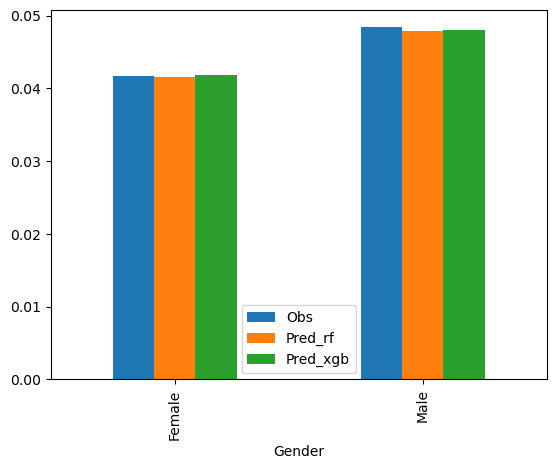

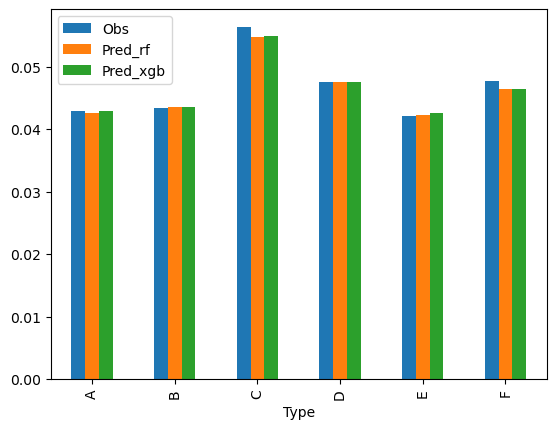

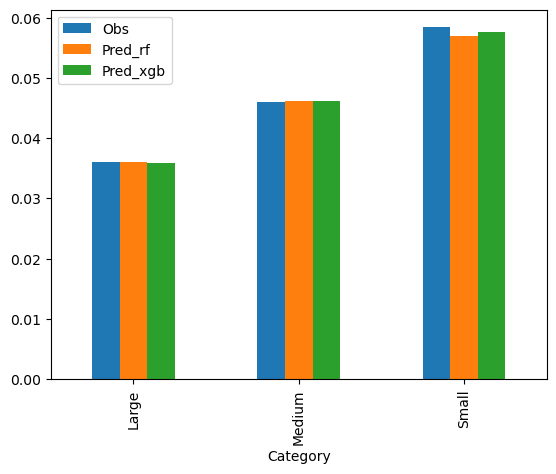

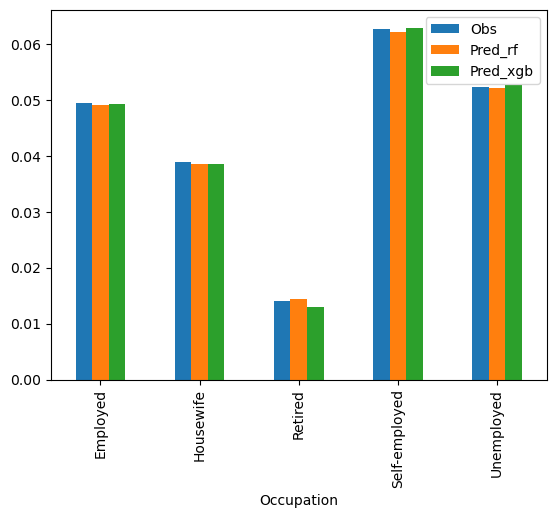

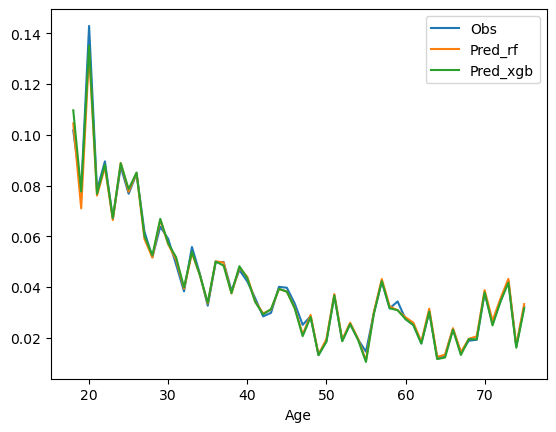

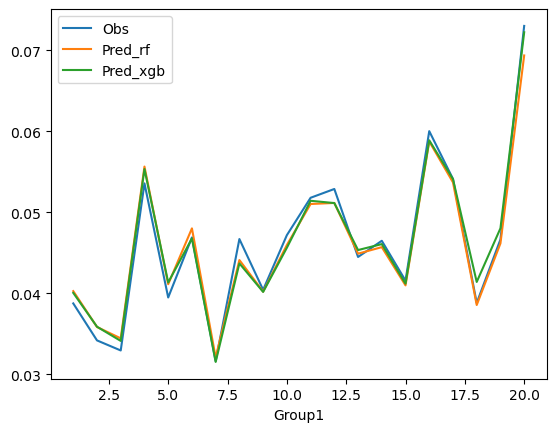

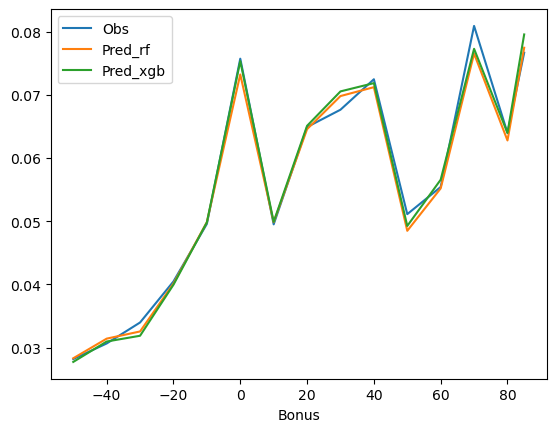

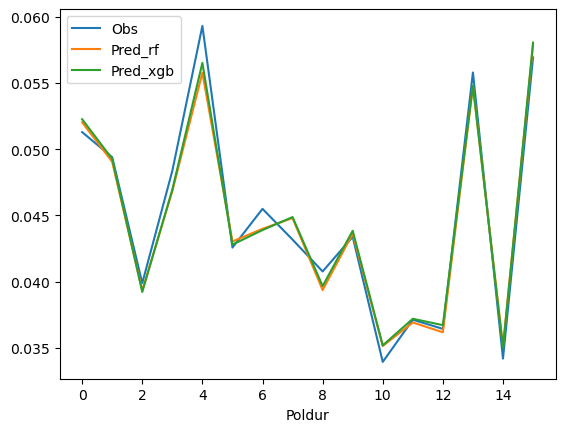

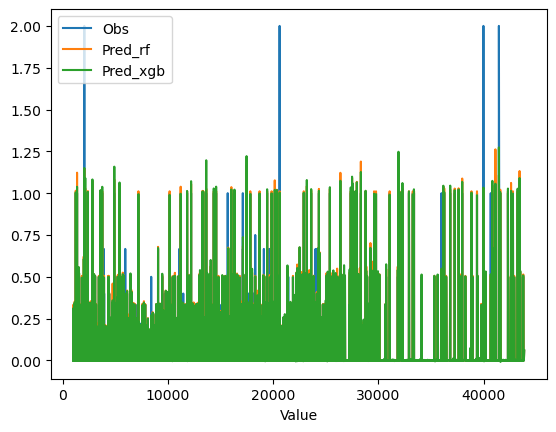

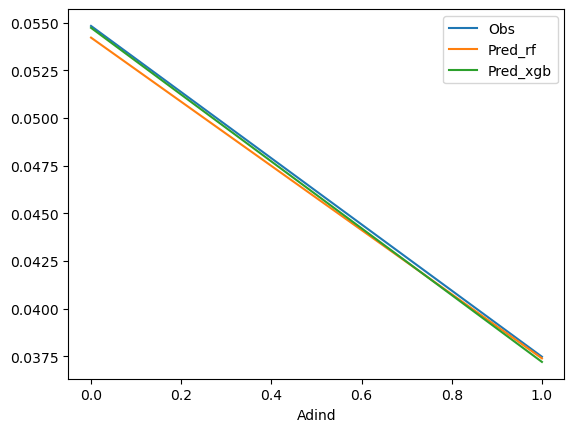

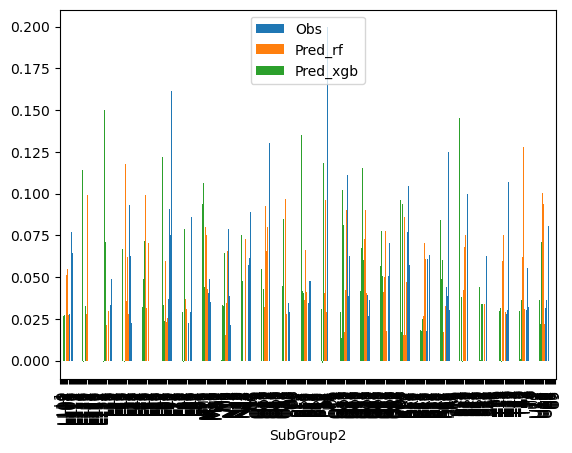

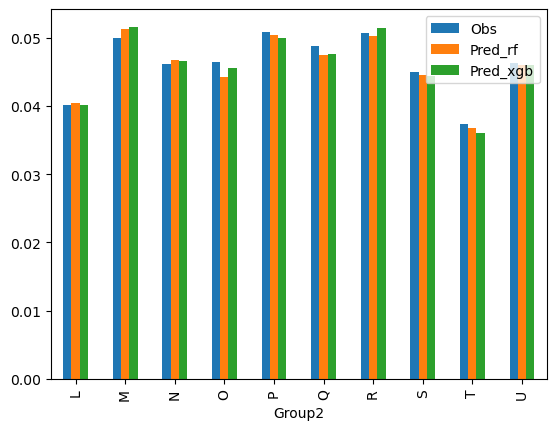

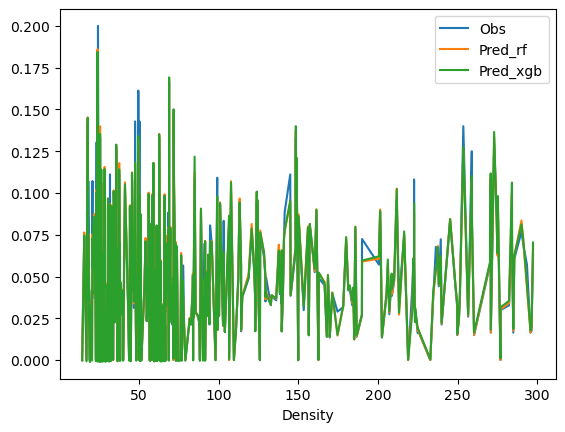

In [17]:
for var in dataFinale.columns[3:16]:
#     dataFinale.groupby([var])[['Obs', 'Pred_model', 'Pred_knn', 'Pred_tree', 'Pred_xgb']].mean().plot()
    dataPlot = dataFinale.groupby([var])[['Obs','Pred_rf', 'Pred_xgb']].mean()
        
    if dataFinale[var].dtypes == 'O':
        dataPlot.plot(kind='bar')
    else:
        dataPlot.plot()